### Loading packages

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

Global seed set to 0


In [2]:
import os

In [3]:
# import gc
# import torch

## Functions

In [4]:
def read_and_qc(sample_name, path):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join='-')
    
    adata.obs['sample'] = sample_name
    
    # rename genes to ENSEMBL
    adata.var['SYMBOL'] = adata.var_names
    adata.var_names = adata.var['gene_ids']
    adata.var_names.name = None

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('MT-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

## Read in metadata

In [5]:
meta=pd.read_csv('/nfs/team205/heart/anndata_objects/Foetal/metadata/HeartTeamSamples_Mappeddata_20230208.csv',
                index_col=0)
meta=meta[['Publication','sangerID', 'combinedID',
       'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender',
       'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status']]

# select slides for foetal publication
meta=meta[meta['Publication'].isin(['Foetal'])]
# select only OCT slides
meta=meta[meta['modality'].isin(['Visium'])]
# select only Healthy slides
meta=meta[meta['status'].isin(['Healthy'])]

In [6]:
# select slides which contain DuctusArterious
sampleIDs = ['HCAHeartST10298118','HCAHeartST10298119','HCAHeartST10298121','HCAHeartST10317187','HCAHeartST10317188']
meta = meta[meta['sangerID'].isin(sampleIDs)]
meta

,Publication,sangerID,combinedID,donor,donor_type,region,region_finest,age,gender,facility,cell_or_nuclei,modality,kit_10x,flushed,status
ID,,,,,,,,,,,,,,,
HCAHeartST10298118,Foetal,HCAHeartST10298118,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy
HCAHeartST10298119,Foetal,HCAHeartST10298119,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy
HCAHeartST10298121,Foetal,HCAHeartST10298121,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy
HCAHeartST10317187,Foetal,HCAHeartST10317187,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy
HCAHeartST10317188,Foetal,HCAHeartST10317188,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy


## Data, parameters

In [7]:
results_folder = '/nfs/team205/heart/cell2location/foetal'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures/ver28Feb2023/whole_woPeriCell'
run_name = f'{results_folder}/cell2location_map/ver28Feb2023'

In [8]:
visium_path='/nfs/team205/heart/mapped/spaceranger110/'

celltype_key='fine_grain'

## Loading visium data

In [9]:
# Read the data of the interested region into anndata objects
slides = []
for i in sampleIDs:
    slides.append(read_and_qc(i, path=visium_path))

# Combine anndata objects together
adata_vis = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sampleIDs,
    index_unique=None
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [10]:
print(adata_vis.shape)
adata_vis.obs['sample'].value_counts()

(5552, 33538)


HCAHeartST10298121    1180
HCAHeartST10298119    1176
HCAHeartST10298118    1106
HCAHeartST10317188    1083
HCAHeartST10317187    1007
Name: sample, dtype: int64

Trying to set attribute `._uns` of view, copying.
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
Trying to set attribute `._uns` of view, copying.
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/seaborn/distributions.py:2657: RuntimeWarning: Mean of empty slice.
Trying to set attribute `._uns` of view, copying.
Trying to set attribute `._uns` of view, copying.
Trying to set attribute `._uns` of view, copying.


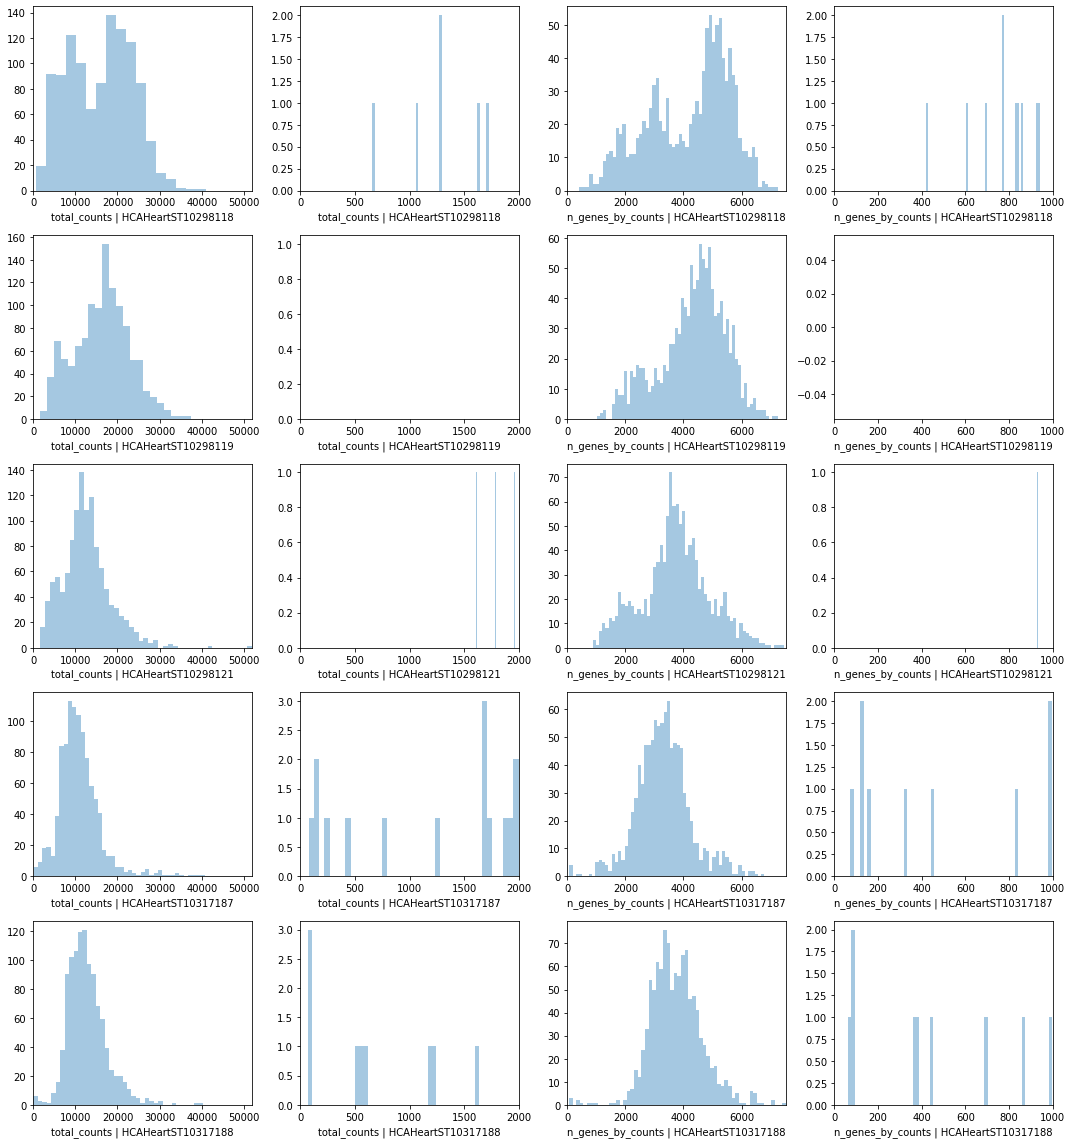

In [11]:
# PLOT QC FOR EACH SAMPLE
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i, s in enumerate(adata_vis.obs['sample'].unique()):
    #fig.suptitle('Covariates for filtering')

    slide = select_slide(adata_vis, s)
    sns.distplot(slide.obs['total_counts'],
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata_vis.obs['total_counts'].max())
    axs[i, 0].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['total_counts']\
                 [slide.obs['total_counts']<2000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 2000)
    axs[i, 1].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata_vis.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel(f'n_genes_by_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts']\
                 [slide.obs['n_genes_by_counts']<1000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 1000)
    axs[i, 3].set_xlabel(f'n_genes_by_counts | {s}')

plt.tight_layout()

## Add metadata and annotation

In [12]:
# metadata
adata_vis.obs = adata_vis.obs.reset_index().merge(meta, how='left', left_on='sample', right_on='sangerID').set_index('spot_id')
adata_vis

AnnData object with n_obs × n_vars = 5552 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'Publication', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL', 'mt', 'n_cells_by_counts-HCAHeartST10298118', 'mean_counts-HCAHeartST10298118', 'log1p_mean_counts-HCAHeartST10298118', 'pct_dropout_by_counts-HCAHeartST10298118', 'total_counts-HCAHeartST10298118', 'log1p_total_counts-HCAHeartST10298118', 'n_cells_by_counts-HCAHeartST10298119', 'mean_counts-HCAHeartST10298119', 'log1p_mean_counts-HCAHeartST10298119', 'pct_dropout_by_counts-HCAHeartST10298119', 'total_counts-HCAHeartST10298119', 

In [13]:
adata_vis.obs.head()

,in_tissue,array_row,array_col,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,...,region,region_finest,age,gender,facility,cell_or_nuclei,modality,kit_10x,flushed,status
spot_id,,,,,,,,,,,,,,,,,,,,,
HCAHeartST10298118_AAACAGAGCGACTCCT-1,1,14,94,HCAHeartST10298118,2840,7.951911,6261.0,8.742255,21.673854,31.288931,...,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy
HCAHeartST10298118_AAACCGTTCGTCCAGG-1,1,52,42,HCAHeartST10298118,3331,8.111328,11000.0,9.305741,33.845455,44.963636,...,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy
HCAHeartST10298118_AAACCTAAGCAGCCGG-1,1,65,83,HCAHeartST10298118,5476,8.608313,24362.0,10.100821,30.038585,40.776619,...,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy
HCAHeartST10298118_AAACTCGGTTCGCAAT-1,1,66,70,HCAHeartST10298118,5697,8.647871,23304.0,10.056423,25.502060,36.800549,...,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy
HCAHeartST10298118_AAACTGCTGGCTCCAA-1,1,45,67,HCAHeartST10298118,5880,8.679482,28207.0,10.247361,28.510653,39.227851,...,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy


In [14]:
# annotation
path_to_annot='/nfs/team205/heart/visium_annotations/foetal'
category_name='JC_edit'

# read in annotation csv file and concatenate
for i, ID in enumerate(sampleIDs):
    if f'{ID}_JC.csv' in os.listdir(path_to_annot):
    
        print(ID)
        annot_df = pd.read_csv(f'{path_to_annot}/{ID}_JC.csv')
        annot_df['spot_id']=ID+'_'+annot_df['Barcode']

        if i==0:
            annot_df_all=annot_df.copy()
        else:
            annot_df_all=pd.concat([annot_df_all,annot_df])
    else:
        print(f'{ID} is not annotated')

# add annotations to adata_vis
adata_vis.obs=pd.concat([adata_vis.obs,
                     annot_df_all.set_index('spot_id')[[category_name]].reindex(adata_vis.obs.index)],
                     axis=1)
# replace nan to 'none'
adata_vis.obs[category_name].fillna('none', inplace=True)

# minor modification
annotation_edit_dict = {
     'AV Ring':'AV ring',
    'Aorta':'Great vessels',
    'Coronary Artery':'Coronary artery',
    'Mitral Valve':'AV valves',
    'Mitral valve':'AV valves',
    'Myocardium - Ventricular - Trabecular':'Myocardium - Ventricular - Trabeculated',
    'Myocardim - Ventricular - Trabeculated':'Myocardium - Ventricular - Trabeculated',
    'Myocardim - Ventricular - Compact':'Myocardium - Ventricular - Compact',
    'unknown':'Unannotated',
    'Unknown':'Unannotated',
}
adata_vis.obs.replace({category_name:annotation_edit_dict}, inplace=True)
set(adata_vis.obs[category_name])

HCAHeartST10298118
HCAHeartST10298119
HCAHeartST10298121
HCAHeartST10317187
HCAHeartST10317188


{'Cavity',
 'Epicardium',
 'Great vessels',
 'Myocardium - Atrial',
 'Myocardium - Ventricular - Compact',
 'Myocardium - Ventricular - Trabeculated',
 'none'}

## Remove spots based on manual annotation

In [15]:
# remove 'none' and 'no_tissue'
adata_vis = adata_vis[adata_vis.obs[category_name].isin(['none','Out_of_tissue'])==False]

# remove 'Cavity'
adata_vis = adata_vis[adata_vis.obs[category_name].isin(['Cavity'])==False]

# remove 'Unannotated'
adata_vis = adata_vis[adata_vis.obs[category_name].isin(['Unannotated'])==False]

In [16]:
# order annotations
annotations_order = ['Myocardium - Atrial',
                     'Myocardium - Ventricular - Compact',
                     'Myocardium - Ventricular - Trabeculated',
                    # 'Myocardium - Papillary Muscle',
                    'Epicardium',
                     # 'AV valves',
                     # 'Aortic valve',
                    # 'Valve apparatus',
                   # 'AV ring',
                    # 'Connective tissue',
                     'Great vessels',
                     # 'Coronary artery',
                     # 'Nerve',
                     ]
adata_vis.obs[category_name] = adata_vis.obs[category_name].astype('category')
adata_vis.obs[category_name].cat.reorder_categories(annotations_order,inplace=True)

Trying to set attribute `.obs` of view, copying.
/tmp/ipykernel_26774/3723571678.py:17: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.


In [17]:
pd.crosstab(adata_vis.obs['age'],adata_vis.obs[category_name])

JC_edit,Myocardium - Atrial,Myocardium - Ventricular - Compact,Myocardium - Ventricular - Trabeculated,Epicardium,Great vessels
age,,,,,
GA-9w4d,433,2141,1129,347,1384


## Filter out low quality spots

In [18]:
# filter out low quality spots
sc.pp.filter_cells(adata_vis, min_counts = 500)
sc.pp.filter_cells(adata_vis, min_genes = 300)

# Spot number per slide
adata_vis.obs['sample'].value_counts()

HCAHeartST10298121    1151
HCAHeartST10298119    1139
HCAHeartST10298118    1082
HCAHeartST10317188    1070
HCAHeartST10317187     991
Name: sample, dtype: int64

## Remove mitochondrial genes

In [19]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]
print(sum(adata_vis.var['MT_gene']))
    
# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]
print(sum(adata_vis.var['MT_gene']))

13
0


## Run cell2location mapping

In [22]:
# convert adata_vis.var_names to symbol
adata_vis.var.set_index('SYMBOL',inplace=True)
adata_vis.var.head()

,gene_ids,feature_types,genome,mt,n_cells_by_counts-HCAHeartST10298118,mean_counts-HCAHeartST10298118,log1p_mean_counts-HCAHeartST10298118,pct_dropout_by_counts-HCAHeartST10298118,total_counts-HCAHeartST10298118,log1p_total_counts-HCAHeartST10298118,...,pct_dropout_by_counts-HCAHeartST10317187,total_counts-HCAHeartST10317187,log1p_total_counts-HCAHeartST10317187,n_cells_by_counts-HCAHeartST10317188,mean_counts-HCAHeartST10317188,log1p_mean_counts-HCAHeartST10317188,pct_dropout_by_counts-HCAHeartST10317188,total_counts-HCAHeartST10317188,log1p_total_counts-HCAHeartST10317188,MT_gene
SYMBOL,,,,,,,,,,,,,,,,,,,,,
A1BG,ENSG00000121410,Gene Expression,GRCh38,False,24,0.026221,0.025883,97.830018,29.0,3.401197,...,98.609732,16.0,2.833213,20,0.019391,0.019205,98.153278,21.0,3.091043,False
A2M,ENSG00000175899,Gene Expression,GRCh38,False,658,1.507233,0.919180,40.506329,1667.0,7.419381,...,52.532274,951.0,6.858565,599,1.249308,0.810622,44.690674,1353.0,7.210818,False
A4GALT,ENSG00000128274,Gene Expression,GRCh38,False,583,1.047016,0.716383,47.287523,1158.0,7.055313,...,50.546177,774.0,6.652863,545,0.810711,0.593720,49.676824,878.0,6.778785,False
AAAS,ENSG00000094914,Gene Expression,GRCh38,False,425,0.528933,0.424570,61.573237,585.0,6.373320,...,70.804369,365.0,5.902633,355,0.402585,0.338317,67.220683,436.0,6.079933,False
AACS,ENSG00000081760,Gene Expression,GRCh38,False,223,0.253165,0.225672,79.837251,280.0,5.638355,...,83.118173,189.0,5.247024,205,0.225300,0.203186,81.071099,244.0,5.501258,False


In [23]:
%%time

# read in reference signatures
inf_aver = pd.read_csv(f"{ref_run_name}/inf_aver.csv", index_col=0)

# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()
print(f'shape of inf_aver: {inf_aver.shape}')
print('reference cell types')
print(inf_aver.columns)

# subset adata
adata_vis=adata_vis.copy()
# prepare anndata for cell2location model
scvi.data.setup_anndata(adata=adata_vis, batch_key="sample")
scvi.data.view_anndata_setup(adata_vis)

shape of inf_aver: (16306, 58)
reference cell types
Index(['AtrialCardiomyocytesLeft', 'AtrialCardiomyocytesRight',
       'VentricularCardiomyocytesLeftCompact',
       'VentricularCardiomyocytesRightCompact',
       'VentricularCardiomyocytesLeftTrabeculated',
       'VentricularCardiomyocytesRightTrabeculated',
       'SinoatrialNodeCardiomyocytes', 'AtrioventricularNodeCardiomyocytes',
       'VentricularConductionSystemProximal',
       'VentricularConductionSystemDistal',
       'GreatVesselAdventitialFibroblasts',
       'CoronaryVesselAdventitialFibroblasts',
       'MyocardialInterstitialFibroblasts1',
       'MyocardialInterstitialFibroblasts2', 'Myofibroblasts',
       'LymphNodeFibroblasticReticularCells', 'ValveInterstitialCells',
       'GreatVesselSmoothMuscleCells', 'CoronarySmoothMuscleCells',
       'DuctusArteriosusSmoothMuscleCells', 'CoronaryPericytes',
       'GreatVesselArterialEndothelialCells',
       'GreatVesselVenousEndothelialCells', 'CoronaryArterialEndoth

/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 5433 cells, 16306 vars, 5 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.4.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 5433  │
│             Vars             │ 16306 │
│            Labels            │   1   │
│           Batches            │   5   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                         Batch Categories                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃     Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ HCAHeartST10298118 │          0          │
│                     │ HCAHeartST10298119 │          1          │
│                     │ HCAHeartST10298121 │          2          │
│                     │ HCAHeartST10317187 │          3          │
│                     │ HCAHeartST10317188 │          4          │
└─────────────────────┴────────────────────┴─────────────────────┘

CPU times: user 1.15 s, sys: 283 ms, total: 1.43 s
Wall time: 1.43 s


In [25]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver, 
    # the expected average cell abundance: tissue-dependent 
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=20,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=20
) 
adata_vis.var.head()

,gene_ids,feature_types,genome,mt,n_cells_by_counts-HCAHeartST10298118,mean_counts-HCAHeartST10298118,log1p_mean_counts-HCAHeartST10298118,pct_dropout_by_counts-HCAHeartST10298118,total_counts-HCAHeartST10298118,log1p_total_counts-HCAHeartST10298118,...,pct_dropout_by_counts-HCAHeartST10317187,total_counts-HCAHeartST10317187,log1p_total_counts-HCAHeartST10317187,n_cells_by_counts-HCAHeartST10317188,mean_counts-HCAHeartST10317188,log1p_mean_counts-HCAHeartST10317188,pct_dropout_by_counts-HCAHeartST10317188,total_counts-HCAHeartST10317188,log1p_total_counts-HCAHeartST10317188,MT_gene
SYMBOL,,,,,,,,,,,,,,,,,,,,,
A1BG,ENSG00000121410,Gene Expression,GRCh38,False,24,0.026221,0.025883,97.830018,29.0,3.401197,...,98.609732,16.0,2.833213,20,0.019391,0.019205,98.153278,21.0,3.091043,False
A2M,ENSG00000175899,Gene Expression,GRCh38,False,658,1.507233,0.919180,40.506329,1667.0,7.419381,...,52.532274,951.0,6.858565,599,1.249308,0.810622,44.690674,1353.0,7.210818,False
A4GALT,ENSG00000128274,Gene Expression,GRCh38,False,583,1.047016,0.716383,47.287523,1158.0,7.055313,...,50.546177,774.0,6.652863,545,0.810711,0.593720,49.676824,878.0,6.778785,False
AAAS,ENSG00000094914,Gene Expression,GRCh38,False,425,0.528933,0.424570,61.573237,585.0,6.373320,...,70.804369,365.0,5.902633,355,0.402585,0.338317,67.220683,436.0,6.079933,False
AACS,ENSG00000081760,Gene Expression,GRCh38,False,223,0.253165,0.225672,79.837251,280.0,5.638355,...,83.118173,189.0,5.247024,205,0.225300,0.203186,81.071099,244.0,5.501258,False


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:34<00:00, 29.37it/s]


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sample' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'Publication' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. 

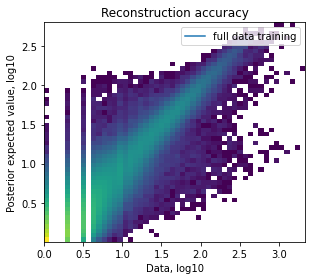

In [26]:
mod.train(max_epochs=20000, 
          # train using full data (batch_size=None)
          batch_size=None, 
          # use all data points in training because 
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}/DuctusArteriosus", overwrite=True)

# Save anndata object with results
adata_vis.write(f"{run_name}/DuctusArteriosus/sp.h5ad")

# Examine reconstruction accuracy to assess if there are any issues with mapping
# the plot should be roughly diagonal, strong deviations will signal problems
mod.plot_QC()